# Fallback Model Benchmark – Logistic vs XGBoost vs RF vs Neural Net

In this notebook, we evaluate several classification models for customer churn prediction **without textual feedback**. This simulates a realistic fallback scenario where structured data is available, but customer comments are missing.

We compare four different models:
- **Logistic Regression (baseline & tuned)**
- **Random Forest (tuned)**
- **XGBoost (tuned)**
- **Neural Network (MLP, tuned)**

We assess each model using **ROC AUC**, **accuracy**, **F1-score**, and **confusion matrices**. Later, this model will be used as a base for a hybrid approach (in Notebook 3), where synthetic features derived from text-based models will be introduced to boost fallback performance.



### Project Structure:

1. **Exploring Customer Churn & GPT-generated Feedback**  
   → Data exploration & text insights

2. **Feedback Noise Simulation & Fallback Testing**  
   → Simulate real-world feedback imperfections

3. **Fallback Model – Logistic vs XGB vs RF vs NN**  
   → Structured-only models, compared & evaluated

4. **Model with Feedback – Logistic vs XGB vs NN**  
   → Hybrid modeling using structured + textual data

5. **Prediction using Synthetic Feedback Knowledge**  
   → Transfer feedback model knowledge to fallback model


## 📑 Table of Contents

[1. Imports & Config](#1-imports--config)  
[2. Load data](#2-load-data)  
[3. Preparing data](#3-preparing-data)  
[4. Set models](#4-set-models)  
[5. Tuning models](#5-tuning-models)  
[6. Evaluation](#6-evaluation)  
[7. Mid Summary](#7-mid-summary)  
[8. Logistic Regression Tuning (GridSearchCV)](#8-logistic-regression-tuning-gridsearchcv)  
[9. Summary](#9-summary)  
[📁 Notebook Series Overview: Telco Churn & GPT Feedback](#notebook-series-overview-telco-churn--gpt-feedback)


## 1. Imports & Config
<a id="1-imports--config"></a>


In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV


import matplotlib.pyplot as plt
import seaborn as sns

from textblob import TextBlob

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
pd.set_option('display.max_colwidth', None)

## 2. Load data
<a id="2-load-data"></a>


In [3]:
df = pd.read_csv('/kaggle/input/telco-customer-churn-realistic-customer-feedback/telco_noisy_feedback_prep.csv')
df.head()

,Unnamed: 0.1,Unnamed: 0,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,...,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,CustomerFeedback,feedback_length,sentiment,HasFeedback
0,0,0,7590-vhveg,female,0,yes,no,1,no,no phone service,...,month-to-month,yes,electronic check,29.85,29.85,0,NaN,0,0.0,False
1,1,1,5575-gnvde,male,0,no,no,34,yes,no,...,one year,no,mailed check,56.95,1889.50,0,NaN,0,0.0,False
2,2,2,3668-qpybk,male,0,no,no,2,yes,no,...,month-to-month,yes,mailed check,53.85,108.15,1,NaN,0,0.0,False
3,3,3,7795-cfocw,male,0,no,no,45,no,no phone service,...,one year,no,bank transfer (automatic),42.30,1840.75,0,NaN,0,0.0,False
4,4,4,9237-hqitu,female,0,no,no,2,yes,no,...,month-to-month,yes,electronic check,70.70,151.65,1,NaN,0,0.0,False


## 3. Preaparing data
<a id="3-preparing-data"></a>


In [4]:
# ==== Feature config ====
numeric_features_clean = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_features_clean = ["Contract", "PaymentMethod", "InternetService", 
    "Partner", "Dependents"]


# Model columns
features_clean = numeric_features_clean + categorical_features_clean + ["Churn"]

# preaparing data
df_clean_structural = df[features_clean].copy()


X = df_clean_structural.drop("Churn", axis=1)
y = df_clean_structural["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

X_train.shape, X_test.shape

((4922, 8), (2110, 8))

In [5]:
# ==== Preprocessor ====
preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numeric_features_clean),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features_clean)
])

## 4. Set models
<a id="4-set-models"></a>


In [6]:
base_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    "Neural Net (MLP)": MLPClassifier(hidden_layer_sizes=(32, 16), max_iter=300, random_state=42)
}

base_results = {}

for name, model in base_models.items():
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)[:, 1]
    
    report = classification_report(y_test, y_pred, output_dict=True)
    auc = roc_auc_score(y_test, y_prob)
    base_results[name] = {
        "f1-score": report["weighted avg"]["f1-score"],
        "accuracy": report["accuracy"],
        "roc_auc": auc
    }

# To table
base_results_df = pd.DataFrame(base_results).T.sort_values("roc_auc", ascending=False)
print("Baseline model performance:")
display(base_results_df)


Baseline model performance:


,f1-score,accuracy,roc_auc
Logistic Regression,0.791164,0.800474,0.841114
Neural Net (MLP),0.785831,0.794313,0.839810
XGBoost,0.765211,0.773460,0.814783
Random Forest,0.755449,0.766351,0.795387


## 5. Tunning models
<a id="5-tuning-models"></a>


In [7]:
# ==== Param grids ====
rf_grid = {
    "classifier__n_estimators": [50, 100],
    "classifier__max_depth": [5, 10],
    "classifier__max_features": ["sqrt"]
}

xgb_grid = {
    "classifier__n_estimators": [50, 100],
    "classifier__learning_rate": [0.05, 0.1],
    "classifier__max_depth": [3, 6]
}

mlp_grid = {
    "classifier__hidden_layer_sizes": [(32,), (64, 32)],
    "classifier__alpha": [0.0001, 0.001],
    "classifier__solver": ["adam"]
}

In [8]:
searches = {
    "Random Forest": GridSearchCV(Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", RandomForestClassifier(random_state=42))
    ]), rf_grid, cv=3, scoring="f1", n_jobs=-1),

    "XGBoost": GridSearchCV(Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42))
    ]), xgb_grid, cv=3, scoring="f1", n_jobs=-1),

    "Neural Net (MLP)": GridSearchCV(Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", MLPClassifier(max_iter=300, random_state=42))
    ]), mlp_grid, cv=3, scoring="f1", n_jobs=-1)
}

search_results = {}
for name, search in searches.items():
    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]

    report = classification_report(y_test, y_pred, output_dict=True)
    auc = roc_auc_score(y_test, y_prob)

    search_results[name] = {
        "f1-score": report["weighted avg"]["f1-score"],
        "accuracy": report["accuracy"],
        "roc_auc": auc,
        "best_params": search.best_params_
    }

# Format results
search_df = pd.DataFrame(search_results).T.sort_values("roc_auc", ascending=False)
search_df.reset_index(inplace=True)
search_df.rename(columns={"index": "Model"}, inplace=True)

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

In [9]:
print("Grid Search Results:")
display(search_df)

Grid Search Results:


,Model,f1-score,accuracy,roc_auc,best_params
0,XGBoost,0.784146,0.794787,0.848366,"{'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}"
1,Neural Net (MLP),0.792775,0.799526,0.843195,"{'classifier__alpha': 0.001, 'classifier__hidden_layer_sizes': (32,), 'classifier__solver': 'adam'}"
2,Random Forest,0.780931,0.791469,0.832419,"{'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__n_estimators': 100}"


In [10]:
print("Baseline model performance:")
base_results_df.head(1)

Baseline model performance:


,f1-score,accuracy,roc_auc
Logistic Regression,0.791164,0.800474,0.841114


## 6. Evaluation
<a id="6-evaluation"></a>


/tmp/ipykernel_13/4211469331.py:15: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


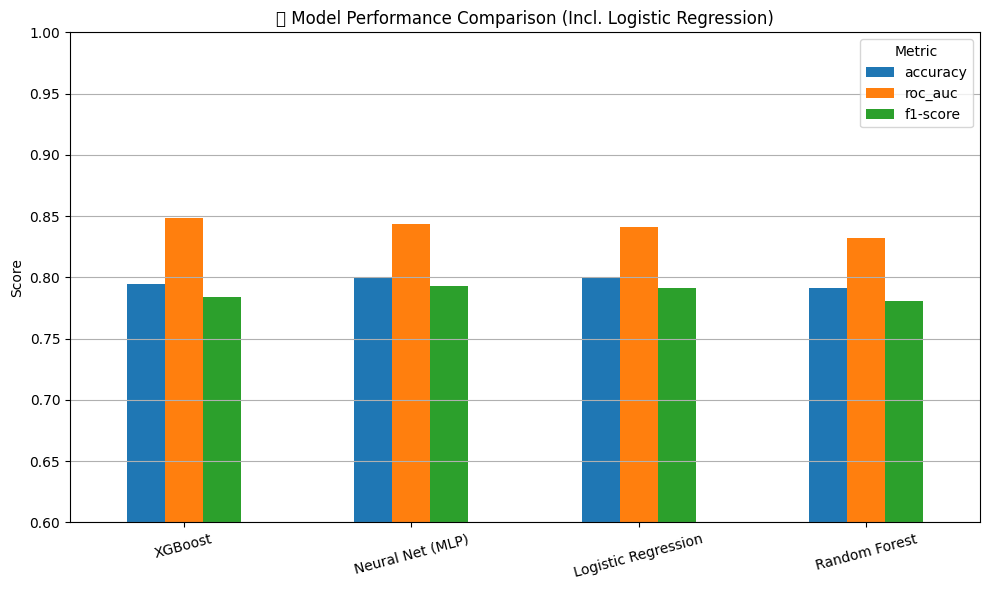

In [11]:
# Show models performance
logreg_row = base_results_df.loc[["Logistic Regression"]].copy()
logreg_row["best_params"] = "default"

search_df_merged = search_df.set_index("Model")[["f1-score", "accuracy", "roc_auc", "best_params"]]
combined_df = pd.concat([search_df_merged, logreg_row], axis=0)
combined_df = combined_df.sort_values("roc_auc", ascending=False)
combined_df[["accuracy", "roc_auc", "f1-score"]].plot(kind="bar", figsize=(10, 6))
plt.title("📊 Model Performance Comparison (Incl. Logistic Regression)")
plt.ylabel("Score")
plt.ylim(0.6, 1.0)
plt.grid(axis='y')
plt.xticks(rotation=15)
plt.legend(title="Metric")
plt.tight_layout()
plt.show()


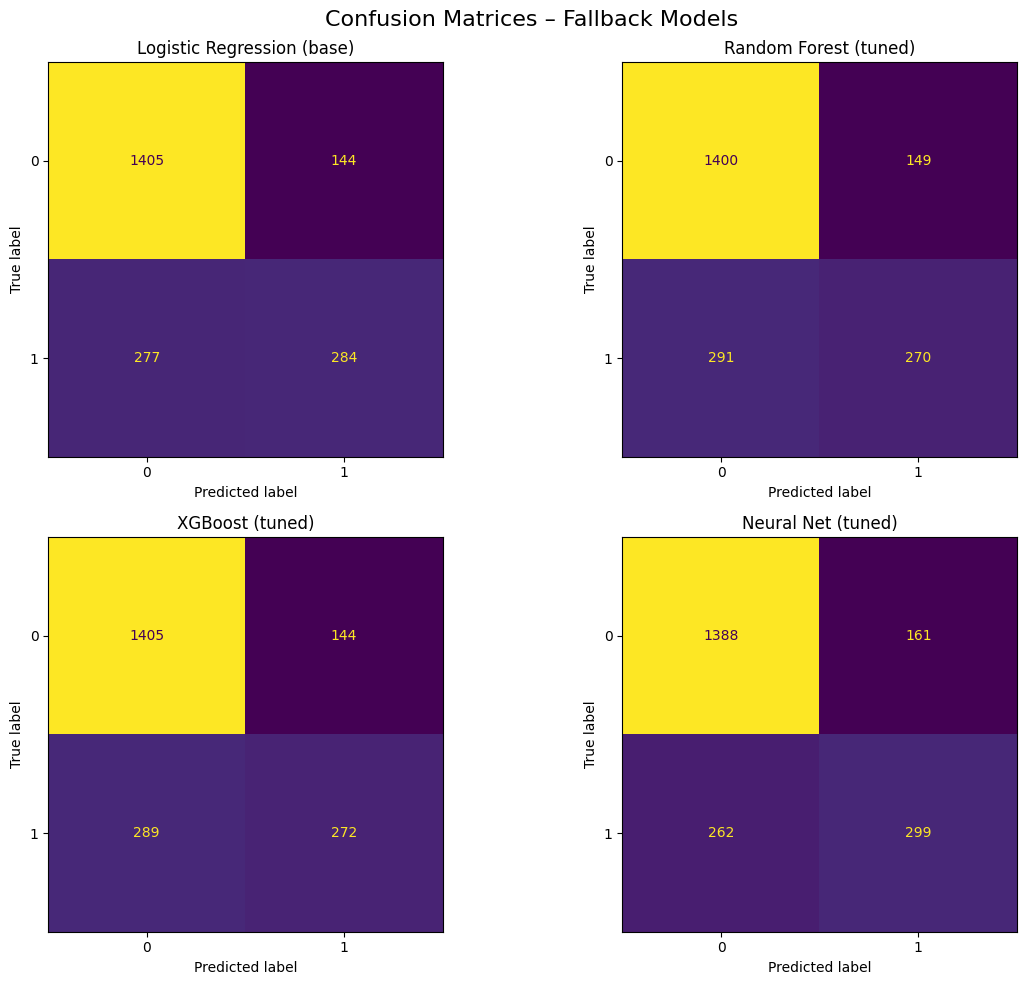

In [12]:
# Logistic Regression
pipe_logreg = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])
pipe_logreg.fit(X_train, y_train)
y_pred_logreg = pipe_logreg.predict(X_test)

# Best models from GridSearch
best_rf = searches["Random Forest"].best_estimator_
best_xgb = searches["XGBoost"].best_estimator_
best_mlp = searches["Neural Net (MLP)"].best_estimator_

# Prepare all predictions
model_preds = {
    "Logistic Regression (base)": y_pred_logreg,
    "Random Forest (tuned)": best_rf.predict(X_test),
    "XGBoost (tuned)": best_xgb.predict(X_test),
    "Neural Net (tuned)": best_mlp.predict(X_test)
}

# Plot confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for ax, (model_name, preds) in zip(axes, model_preds.items()):
    ConfusionMatrixDisplay.from_predictions(y_test, preds, ax=ax, colorbar=False)
    ax.set_title(model_name)

plt.suptitle("Confusion Matrices – Fallback Models", fontsize=16)
plt.tight_layout()
plt.show()


## 7. Mid Summary 
<a id="7-mid-summary"></a>



At this stage, we benchmarked four different classification models for churn prediction without textual feedback (fallback scenario). The models include: 
* Logistic Regression (baseline), 
* Random Forest (tuned via GridSearchCV)
* XGBoost (tuned)
* Neural Network (MLP, tuned)

Key findings:
Logistic Regression (default hyperparameters) performed best in terms of AUC and accuracy, outperforming more complex models.

This suggests that the relationship between structured features and churn is relatively linear or easily separable.

Despite tuning, ensemble models (Random Forest, XGBoost) did not surpass the logistic baseline in this setting.

In the next step, we will tune Logistic Regression using regularization (C), class weights.

## 8. Logistic Regression Tuning (GridSearchCV)
<a id="8-logistic-regression-tuning-gridsearchcv"></a>


In [13]:
logreg_grid = {
    "classifier__C": [0.01, 0.1, 1.0, 10.0],
    "classifier__class_weight": [None, "balanced"],
    "classifier__penalty": ["l2"],  # keep it simple
    "classifier__solver": ["lbfgs"]
}


In [14]:
pipe_logreg = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000, random_state=42))
])

logreg_search = GridSearchCV(
    pipe_logreg,
    param_grid=logreg_grid,
    scoring="f1",
    cv=3,
    n_jobs=-1
)

logreg_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['tenure',
                                                                          'MonthlyCharges',
                                                                          'TotalCharges']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Contract',
                                                                          'PaymentMethod',
                                                                          'InternetService',
                                                                          'Partner',
                                                                          'Dependents'])])),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.01, 0.1, 1.0, 10.0],
                         'classifier__class_weight': [None, 'balanced'],
                         'classifier__penalty': ['l2'],
                         'classifier__solver': ['lbfgs']},
             scoring='f1')

In [15]:
best_logreg = logreg_search.best_estimator_
y_pred_best_logreg = best_logreg.predict(X_test)
y_prob_best_logreg = best_logreg.predict_proba(X_test)[:, 1]

from sklearn.metrics import classification_report, roc_auc_score

report_logreg = classification_report(y_test, y_pred_best_logreg, output_dict=True)
auc_logreg = roc_auc_score(y_test, y_prob_best_logreg)

print("Best Logistic Regression config:", logreg_search.best_params_)
print("ROC AUC:", round(auc_logreg, 3))
print("Classification Report:")
display(pd.DataFrame(report_logreg).T)


Best Logistic Regression config: {'classifier__C': 0.01, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
ROC AUC: 0.839
Classification Report:


,precision,recall,f1-score,support
0,0.909458,0.726275,0.807609,1549.000000
1,0.514318,0.800357,0.626220,561.000000
accuracy,0.745972,0.745972,0.745972,0.745972
macro avg,0.711888,0.763316,0.716915,2110.000000
weighted avg,0.804400,0.745972,0.759382,2110.000000


## 9. Summary
<a id="9-summary"></a>

At this stage, we benchmarked four different classification models for churn prediction without customer feedback. Surprisingly, the **default Logistic Regression model** outperformed all other models, including those fine-tuned via GridSearch (Random Forest, XGBoost, Neural Net).


- The tuned model achieved better recall — making it preferable in use cases where missing a churn case is more costly than generating false alarms.
- However, the overall ROC AUC slightly decreased, meaning the default model offers a better overall balance. <br>
Logistic Regression remains the best fallback candidate — and will be used in the next phase of this project.


## 📁 Notebook Series Overview: **Telco Churn & GPT Feedback**
<a id="notebook-series-overview-telco-churn--gpt-feedback"></a>

This is part of a multi-notebook series focused on **realistic churn prediction** using structured data and GPT-generated customer feedback.  
We simulate real-world challenges such as missing text, noisy input, and model fallback logic — building toward a robust, production-style solution.

---

###  1. Exploring Customer Churn & GPT-generated Feedback

> Exploratory analysis of the churn dataset, with focus on customer segments, behavior patterns, and text feedback characteristics.  
> Text insights powered by GPT-generated responses.

---

###  2. Feedback Noise Simulation & Fallback Testing

> We simulate feedback imperfections (irrelevant, incomplete, or missing entries) and measure how models perform under noise.  
> Introduces the concept of fallback systems for low-signal situations.

---

### 3. Fallback Model – Logistic vs XGB vs RF vs NN

> We train and compare multiple classifiers on **structured-only data** (no feedback):  
> Logistic Regression, Random Forest, XGBoost, and Neural Net.  
> Best fallback model is selected based on ROC AUC and recall.

---

###  4. Model with Feedback – Logistic vs XGB vs NN

> We focus on customers who left written feedback.  
> Structured data is combined with TF-IDF vectors to train a stronger “teacher” model.  
> Logistic Regression emerges as the most interpretable and best-performing solution.

---

### 5. Prediction using Synthetic Feedback Knowledge

> Even when customers don’t leave feedback, we simulate its predictive signal using the trained teacher model.  
> We generate a `synthetic_text_score` and evaluate whether it helps fallback performance.
